In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rs_datasets import MovieLens

In [4]:
ml = MovieLens('1m')
data = ml.ratings
data

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### EDA

In [5]:
count_user_interaction = data.groupby('user_id')['item_id'].count()
count_item_interaction = data.groupby('item_id')['user_id'].count()

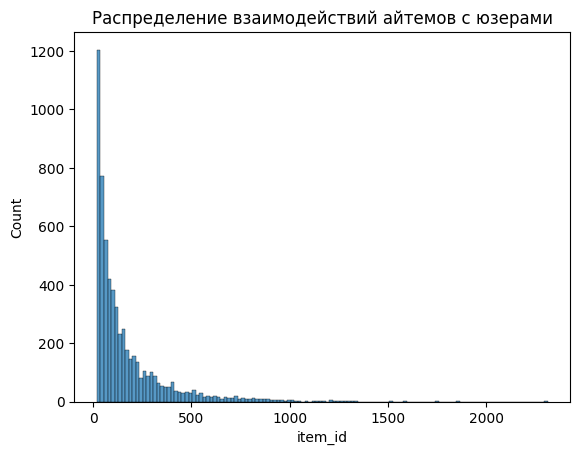

In [6]:
sns.histplot(count_user_interaction)
plt.title('Распределение взаимодействий айтемов с юзерами')
plt.show()

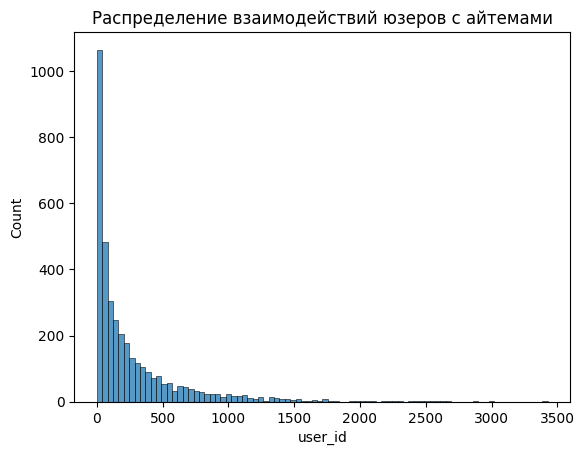

In [7]:
sns.histplot(count_item_interaction)
plt.title('Распределение взаимодействий юзеров с айтемами')
plt.show()

### Фильтрация данных

In [8]:
def drop_duplicates_items(data, user_id='user_id', item_id="item_id", timestamp="timestamp"):
    """Удаление повторяющихся айтемов в последовательности юзера вида i-i-j -> i-j."""

    data.sort_values([user_id, timestamp], inplace=True)
    data['user_item'] = data[user_id].astype(str) + '_' + data[item_id].astype(str)

    while (data['user_item'].shift() == data['user_item']).sum() != 0:
        not_duplicates_ind = data['user_item'].shift() != data['user_item']
        data = data.loc[not_duplicates_ind]

    data = data.drop('user_item', axis=1)

    return data

def filter_items(data, item_min_count, item_id="item_id"):
    """Фильтрация айтемов с малым количеством взаимодействий."""

    counts = data[item_id].value_counts()
    data = data[data[item_id].isin(counts[counts >= item_min_count].index)]

    return data
 
def filter_users(data, min_len, user_id='user_id'):
    """Фильтрация юзеров с малым количеством взаимодействий."""

    counts = data[user_id].value_counts()
    users = counts[counts >= min_len].index
    data = data[data[user_id].isin(users)]

    return data

def FilterN(data, user_id='user_id', item_id='item_id', timestamp='timestamp', item_min_count=50, min_len=50):

    data = drop_duplicates_items(data, user_id, item_id, timestamp)
    data = filter_items(data, item_min_count, item_id)
    data = filter_users(data, min_len, user_id)

    return data 

In [9]:
data = FilterN(data)

In [10]:
count_user_interaction = data.groupby('user_id')['item_id'].count()
count_item_interaction = data.groupby('item_id')['user_id'].count()

Релизация Replay

In [11]:
from replay.preprocessing.filters import NumInteractionsFilter
from replay.preprocessing.filters import LowRatingFilter
from replay.preprocessing.filters import MinCountFilter

In [12]:
data = ml.ratings

In [13]:
data = NumInteractionsFilter(num_interactions=5).transform(data)
data = LowRatingFilter(value=3).transform(data)
data = MinCountFilter(num_entries=5, groupby_column='user_id').transform(data)
data = MinCountFilter(num_entries=5, groupby_column='item_id').transform(data)


### Разбиение данных

#### Случайное разбиение

In [14]:
from replay.splitters.random_splitter import RandomSplitter
train, test = RandomSplitter(test_size=0.1).split(data)

#### Разбиение по пользователям

In [15]:
from replay.splitters.new_users_splitter import NewUsersSplitter
train, test = NewUsersSplitter(test_size=0.1, query_column='user_id').split(data)